### Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import dlib
import random

from google.colab import drive
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import SGDOneClassSVM
from sklearn import svm
from joblib import dump, load

### Augmentation Image

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Specify the full path to the directory
directory_path = '/content/drive/My Drive/Wajah/'

# List all the files in the directory
files = os.listdir(directory_path)
print(files)

['train', 'test', 'preprocess', 'dataset', 'model']


In [ ]:
def convert_and_trim_bb(image, rect):
  startX = 0
  startY = 0
  w = 0
  h = 0
  if len(rect) > 0:
    rect = rect[0]
    # extract the starting and ending (x, y)-coordinates of the
    # bounding box
    startX = rect.left()
    startY = rect.top()
    endX = rect.right()
    endY = rect.bottom()
    # ensure the bounding box coordinates fall within the spatial
    # dimensions of the image
    startX = max(0, startX)
    startY = max(0, startY)
    endX = min(endX, image.shape[1])
    endY = min(endY, image.shape[0])
    # compute the width and height of the bounding box
    w = endX - startX
    h = endY - startY
	  # return our bounding box coordinates

  return (startX, startY, w, h)

### Load Dataset

In [ ]:
def image_face_processing(path, path_output):
  detector = dlib.get_frontal_face_detector()
  kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  # detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  # detector = cv2.CascadeClassifier(args["cascade"])
  files = os.listdir(path)

  if os.path.exists(path_output + "preprocess/") == False:
    os.mkdir(path_output + "preprocess/")

  for i in range(len(files)):
      # List of files in the sub-folder
      if os.path.exists(path_output + "preprocess/" + files[i] + "/") == False:
        os.mkdir(path_output + "preprocess/" + files[i] + "/")

      file_sub = os.listdir(os.path.join(directory_path + "train/", files[i]))  # Use os.path.join to construct the correct path

      for z in range(len(file_sub)):
        try:
          data = cv2.imread(os.path.join(path, files[i], file_sub[z]))
          faces = detector(data)
          crop = convert_and_trim_bb(data, faces)

          if sum(crop) > 1 :
            faces_crop = data[crop[1]:crop[1]+crop[3], crop[0]:crop[0]+crop[2]]
            photo = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
            photo = cv2.equalizeHist(photo)
            photo = clahe.apply(photo)
            photo = cv2.filter2D(photo, -1, kernel)
            cv2.imwrite(path_output + "preprocess/" + files[i] + "/" + file_sub[z], photo)

        except:
          pass


In [ ]:
image_face_processing(directory_path+"train/", directory_path)

In [ ]:
ImgDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

    train_datagen = ImgDataGenerator(
                    rescale=1./255,
                    featurewise_center=True,
                    featurewise_std_normalization=True,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    brightness_range=[0.25, 1.3],
                    rotation_range=20,
                    horizontal_flip=True,
                    fill_mode="nearest",
                    )

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=150,
                                                        class_mode="binary",
                                                        target_size=(160, 160))

    validation_datagen = ImgDataGenerator( rescale=1./255,)

    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=100,
                                                                class_mode="binary",
                                                                target_size=(160, 160))
    return train_generator, validation_generator

In [ ]:
train_generator, test_generator = train_val_generators(directory_path + "dataset/", directory_path + "preprocess/")

Found 4 images belonging to 1 classes.
Found 91 images belonging to 11 classes.


In [ ]:
num_variations = 38
X_train, y_train = [], []

for i in range(num_variations):
    # Generate a batch of one image
    val = random.randint(0, 3)
    a, b = train_generator.next()
    X_train.append(a[0])
    X_train.append(a[2])
    X_train.append(a[1])
    X_train.append(a[3])

    y_train.append(b[0])
    y_train.append(b[2])
    y_train.append(b[1])
    y_train.append(b[3])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test, y_test = test_generator.next()


In [ ]:
print(X_train.shape)
for n in range(len(y_test)):
  if y_test[n] != 0:
    y_test[n] = 1
print(y_test)

(152, 160, 160, 3)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


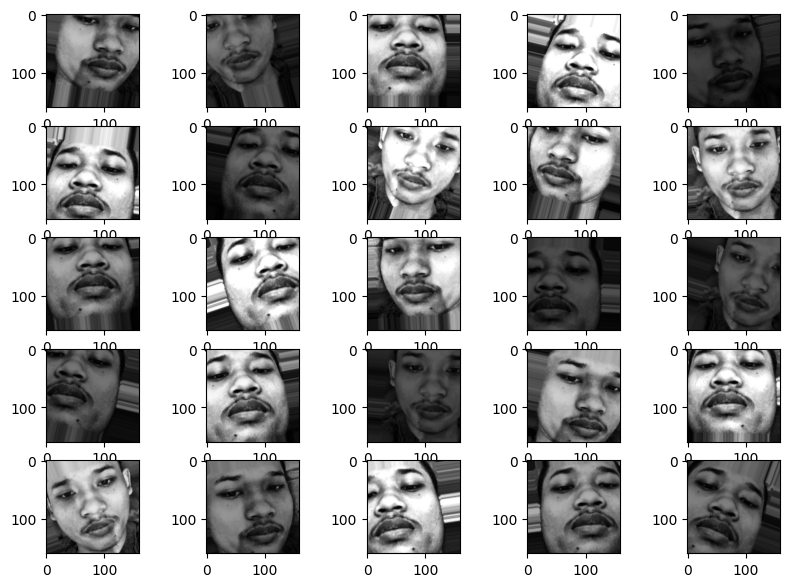

In [ ]:
fig = plt.figure(figsize=(10, 7))


for m in range(25):
  fig.add_subplot(5, 5, m+1)
  plt.imshow(X_train[m])

In [ ]:
# class myCallback(tf.keras.callbacks.Callback):
#         # Define the correct function signature for on_epoch_end
#         def on_epoch_end(self, epoch, logs={}):
#             if logs.get('accuracy') is not None and logs.get('accuracy') > 0.98:
#                 print("\nReached 95% accuracy so cancelling training!")

#                 # Stop training once the above condition is met
#                 self.model.stop_training = True

### Load Inceptionv1 Pre-Trained Model

In [ ]:
pre_train_model = tf.keras.models.load_model(directory_path + "model/")

In [ ]:
def scaler_vector(x):
  return tf.math.l2_normalize(x, axis=1)

lock pre-train model and create new model based on pre-train model

In [ ]:
for layer in pre_train_model.layers:
    layer.trainable = False

facenet_model = tf.keras.models.Sequential()
facenet_model.add(pre_train_model)
facenet_model.add(tf.keras.layers.Lambda(scaler_vector))

In [ ]:
facenet_model.compile()

In [ ]:
# tf.keras.models.save_model(facenet_model,'')
# Now convert best model to tensorflow lite format
# converter = tf.lite.TFLiteConverter.from_keras_model(facenet_model)
# tflite_model = converter.convert()

# #Now save model
# with open("embedding.tflite","wb") as f:
#     f.write(tflite_model)

In [ ]:
# facenet_model.summary()

### Prepare Data for Embedding

In [ ]:
def img_to_encoding(train_data, model):
    img = np.array(train_data) / 255.
    x_train = np.expand_dims(img, axis=0) # add a dimension of 1 as first dimension
    embedding = model.predict(x_train)
    print(np.linalg.norm(embedding))
    return embedding
    # return embedding / np.linalg.norm(embedding, ord=2) # scale embedding result so the magnitude of vector value is 1

Calculate the distance between 2 vector. smaler is better, smaller is more similiar

In [ ]:
def image_load(path):
    img = tf.keras.preprocessing.image.load_img(path, target_size=(160, 160))
    return img

In [ ]:
def verify(image1, image2):
    dist = (np.linalg.norm(tf.subtract(image1, image2), ord=2))
    if dist < 0.98:
        print("It's same, welcome in!")
    else:
        print("It's not same, please go away")
    return dist

In [ ]:
# data1 = facenet_model.predict(np.expand_dims(image_load(directory_path + "preprocess/dewanata/WhatsApp Image 2023-11-14 at 15.56.13.jpeg"), axis=0))
# data2 = facenet_model.predict(np.expand_dims(image_load(directory_path + "preprocess/dewanata/WhatsApp Image 2023-11-14 at 15.56.05.jpeg"), axis=0))
data1 = img_to_encoding(image_load(directory_path + "preprocess/dewanata/WhatsApp Image 2023-11-14 at 15.56.13.jpeg"),facenet_model)
data2 = img_to_encoding(image_load(directory_path + "preprocess/dewanata/WhatsApp Image 2023-11-14 at 15.56.05.jpeg"),facenet_model)
# print(data1.shape)
# embed1 = data1 / np.linalg.norm(data1, ord=2)
# embed2 = data2 / np.linalg.norm(data2, ord=2)
verify(data1, data2)

1/1 [==============================] - 0s 109ms/step
0.99999994
1/1 [==============================] - 0s 91ms/step
0.99999994
It's same, welcome in!


0.93208617

Embedding train and test data to get the vector from image data

In [ ]:
train = facenet_model.predict(X_train)
test = facenet_model.predict(X_test)

3/3 [==============================] - 4s 1s/step


In [ ]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(128,)),
    tf.keras.layers.Dense(1, activation='softplus')
])

new_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
new_model.fit(train, y_train, epochs=5, validation_data=(test, y_test))

Epoch 1/5
3/3 [==============================] - 1s 107ms/step - loss: 0.8667 - accuracy: 0.0750 - val_loss: 0.7780 - val_accuracy: 0.1373
Epoch 2/5
3/3 [==============================] - 0s 29ms/step - loss: 0.5451 - accuracy: 0.9875 - val_loss: 1.0488 - val_accuracy: 0.0000e+00
Epoch 3/5
3/3 [==============================] - 0s 20ms/step - loss: 0.3652 - accuracy: 1.0000 - val_loss: 1.3111 - val_accuracy: 0.0000e+00
Epoch 4/5
3/3 [==============================] - 0s 21ms/step - loss: 0.2542 - accuracy: 1.0000 - val_loss: 1.5609 - val_accuracy: 0.0000e+00
Epoch 5/5
3/3 [==============================] - 0s 20ms/step - loss: 0.1836 - accuracy: 1.0000 - val_loss: 1.7955 - val_accuracy: 0.0000e+00


In [ ]:
predict_data = img_to_encoding(image_load(directory_path+"preprocess/dewanata/WhatsApp Image 2023-11-14 at 15.56.13.jpeg"),facenet_model)
predict_data2 = img_to_encoding(image_load(directory_path+"preprocess/dewi/1.jpg"),facenet_model)

1/1 [==============================] - 0s 171ms/step
0.99999994
1/1 [==============================] - 0s 156ms/step
1.0


In [ ]:
new_model.predict(predict_data)

1/1 [==============================] - 0s 26ms/step


array([[0.11945447]], dtype=float32)

Prepare vector by scaling

In [ ]:
testing = []
for i in test:
    testing.append( i / np.linalg.norm(i, ord=2) )

test = np.array(testing)
test_label = y_test
print(test.shape)
print(y_test.shape)

training = []
for i in train:
    training.append( i / np.linalg.norm(i, ord=2))

train = np.array(training)
train_label = y_train

print(train.shape)
print(train_label.shape)

(47, 128)
(47, 1)
(100, 128)
(100,)


Single image for model to predict

### Using IsolationForest or OneClassSVM for 1 class Classification Model

In [ ]:
oc_svm = svm.OneClassSVM(gamma=0.08, kernel='rbf', nu=0.01)  # Obtained using grid search
if_clf = IsolationForest(contamination=0.025, max_features=1.0, max_samples=1.0, random_state = 3, n_estimators=200)  # Obtained using grid search

In [ ]:
oc_svm.fit(train,y_train)
if_clf.fit(train,y_train)

IsolationForest(contamination=0.025, max_samples=1.0, n_estimators=200,
                random_state=3)

Compare the result

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
pred = if_clf.predict(test)
pred[pred == 1] = 0
pred[pred == -1] = 1

precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

print("________")

pred2 = oc_svm.predict(test)
pred2[pred2 == 1] = 0
pred2[pred2 == -1] = 1
precision = precision_score(y_test, pred2)
recall = recall_score(y_test, pred2)
f1 = f1_score(y_test, pred2)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.92
Recall: 0.56
F1 Score: 0.70
________
Precision: 0.95
Recall: 0.93
F1 Score: 0.94


In [ ]:
dump(if_clf, 'test.joblib')

['test.joblib']

In [ ]:
if_test = load('test.joblib')